In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from math import floor
import leidenalg as la
import igraph as ig
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, window_size, data, **kwargs):
        
        if length < 1: raise ValueError('Object should be a multilayer network with at least 2 layers')
        if size < 3: raise ValueError('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        self.windowsize = window_size
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. Caveat: if you use edge_list only firing neurons are going
        ##                      to be taken ito consideration.
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.multi_array[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.multi_array[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def binarize(self, array):
        n,t = array.shape
        binary_spikes = np.zeros(array.shape)
        for i in range(n):
            for j in range(t):
                if array[i][j] == 0: pass
                else: binary_spikes[i][j] = 1
        return(binary_spikes)
    
    def bin_time_series(self, array, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
    
        n = array.shape[0] # number of neurons
        totalsize = array.shape[1] # total duration of spikes
        gauss_array = np.zeros((n,totalsize))
        binsize = self.windowsize
        l = int(totalsize/binsize) # number of resulting layers
        if gaussian:
            for i in range(n):
                gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
        else: gauss_array = array
        A = np.zeros((l,n,binsize))
        for i in range(l):
            A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
        return(A)
    
    def edgelist2edges(self):# helper to create igraphs
        T = self.length
        all_edges = [[] for i in range(T)]
        all_weights = [[] for i in range(T)]
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            all_weights[t].append(w)
        return (all_edges, all_weights)
    
    def neighbors(self, node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def average_degree(self,layer):
        
        average_degree = 0
        
        for i in range(self.size):
            average_degree = average_degree + len(self.neighbors(i,layer))
        
        return(average_degree/(2*self.size))
    
    def create_igraph(self):
        T = self.length
        N = self.size
        G = []
        edges = self.edgelist2edges()[0]
        weights = self.edgelist2edges()[1]
        for i in range(T):
            G.append(ig.Graph())
            G[i].add_vertices(N)
            G[i].add_edges(edges[i])
            G[i].es['weight'] = weights[i]
            G[i].vs['id'] = list(range(N))
            G[i].vs['node_size'] = 0
        return(G)

    
    def leiden(self, G, interslice, resolution):
        
        layers, interslice_layer, G_full = la.time_slices_to_layers(G, interslice_weight = interslice)
        
        partitions = [la.RBConfigurationVertexPartition(H, 
                                            weights = 'weight', 
                                            resolution_parameter = resolution) for H in layers]
        
        interslice_partition = la.RBConfigurationVertexPartition(interslice_layer, 
                                                                 weights = 'weight',
                                                                 resolution_parameter = 0)
                                                     
        optimiser = la.Optimiser()
        
        diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition])

        return(partitions, interslice_partition)
    
    def membership(self, interslice_partition): ## returns the community assignments from the leiden algorithm as
        ##                                       tuple (n,t) n is the node id t is the layer that node is in
        n = self.size
        membership = [[] for i in range(interslice_partition._len)]
        for i,m in enumerate(interslice_partition._membership):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))
        return(membership, len(membership))
    
    def community(self, membership, ax, pv = None):
        n = self.size
        t = self.length
        number_of_colors = len(membership)


        comms = np.zeros((n,t))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i

        cmap = mpl.colors.ListedColormap(color)

        #fig,ax = plt.subplots(1,1,figsize=(7,5))
        ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower',extent = [-0.5,t-0.5,-0.5,n-0.5])
        ax.set_xticks(np.arange(t))
        if pv is not None: ax.set_yticks(pv)
        ax.tick_params(axis = 'both', labelsize = 13)
        ax.set_xlabel('Layers (Time)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_title('Community Assignments with %d Communities' %len(color), fontsize = 20)
        return(comms, color)
    
    def raster_plot(self, spikes, ax, color = None, **kwargs):#plots the raster plot of the spike activity on a 
        # given axis 'comm_assignment' and 'color' arguments are the outputs of the function 'community' 
        # and they display the community assignment of the spiking activity if provided. if not, raster 
        # ais going to be plotted blue
        binsize = self.windowsize
        binarized_spikes = self.binarize(spikes)
        binned_spikes = self.bin_time_series(binarized_spikes, gaussian = False)
        l,n,t = binned_spikes.shape
        
        sp = np.nonzero(binned_spikes)
        
        if color is None: 
            col = [0]*l
            clr = [col for i in range(n)]
            color = ['#0000ff']
        else: clr = kwargs['comm_assignment']
        
        cmap = mpl.colors.ListedColormap(color)
        
        for i in range(len(sp[0])):
            ax.scatter(sp[0][i]*binsize+sp[2][i],  sp[1][i], 
                       s = 5, 
                       c = color[int(clr[sp[1][i]][sp[0][i]])], 
                       marker = 'x', 
                       figure = fig, 
                       cmap = cmap)
            
        ax.set_title('Raster Plot', fontsize = 20)
        ax.set_xlabel('Time (Frames)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_xticks([t*i for i in range(l+1)])
        ax.set_yticks([5*i for i in range(int(n/5)+1)]+[n])
        ax.tick_params(axis = 'x', labelsize = 10)
        ax.tick_params(axis = 'y', labelsize = 13)

In [3]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [4]:
def read_csv(path, output, subject, roi):
    trace=open( path + output + subject + "_trace.csv", "r")
    spike=open( path + output + subject + "_spikes_complexity.csv", "r")
    reader_trace = csv.reader(trace)
    reader_spike = csv.reader(spike)
    n = read_roi(path, roi, subject)
    traces = np.zeros((n,8000)) # roi x time
    spikes = np.zeros((n,8000)) # roi x time
    #row_count = sum(1 for row in reader)
    
    for i,line in enumerate(reader_trace):
        for j in range(len(line)):
            traces[i][j]=line[j]
    for i,line in enumerate(reader_spike):
        for j in range(len(line)):
            spikes[i][j]=line[j]
    return(traces, spikes)

def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def read_pv(path, m_type, mice):# this only read pv cells so far, TODO extend this to sst and non-track mice
    
    ##m_type: either 'het' or 'wt'
    
    het_or_wt = 'pv_' + m_type
    pvs = load_obj(path, het_or_wt)
    subject = mice.split('_')[0] + '_' + mice.split('_')[1] + '_' + mice.split('_')[2] + '_' + mice.split('_')[3]
    
    if mice.split('_')[-1] == 'baseline':index = 0
    elif mice.split('_')[-1] == 'early':index = 1
    elif mice.split('_')[-1] == 'pre':index = 2
        
    pv_indices=[i-1 for i in pvs[subject][index]]#adjust python indexing starting from 0
    
    return(pv_indices)
            
def read_roi(path, roi, subject_roi):
    roi = read_roi_zip(glob(path+roi+subject_roi +'.zip')[0])
    n = len(roi)
    for i, R in enumerate(roi):
        x = roi[R]['x']
        y = roi[R]['y']
    return(n)

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    gauss_array = np.zeros((n,totalsize))
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            gauss_array[i] = gaussian_filter(array[i],kwargs['sigma'])
    else: gauss_array = array
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = gauss_array[:,i*binsize:(i+1)*binsize]
    return(A)

def binarize(array):
    n,t = array.shape
    binary_spikes = np.zeros((n,t))
    for i in range(n):
        for j in range(t):
            if array[i][j] == 0: pass
            else: binary_spikes[i][j] = 1
    return(binary_spikes)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def spike_count(spikes, num_bins, spy = True, t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    for i in range(n):
        spike_count.append(np.sum(spikes[i][t_min:t_max]))
    n, bins, patches = plt.hist(spike_count, num_bins, facecolor='blue', alpha=0.5)
    if spy: plt.show()
    return(n,bins)

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

In [5]:
num_comms = 1 # number ofcommunities to expand
spike_rate = 10 # spike rate per commiunity
comm_size = [30,30,30,30]
num_neurons = int(sum(comm_size))
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs
seconds = len(comm_size)
total_duration = int(seconds*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
layers = int(total_duration/window_size)

In [6]:
spikes = np.zeros((num_neurons,total_duration))

master_spike = np.zeros((1,total_duration))
master = homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = total_duration*ms, as_array=True) 

for i,e in enumerate(master):    
    master_spike[0][int(e)] = 1
for i in range(comm_size[0]):
    spikes[i] = jitter(master_spike, 5)

comms = []
for i in range(1,len(comm_size)):
    comms.append([homogeneous_poisson_process(rate = spike_rate*Hz, t_start = 0.0*ms, t_stop = i*bin_size*ms, as_array=True) for j in range(comm_size[i])])

neuron_count = comm_size[0]
for i,e in enumerate(comms):## this is for 
    for j,f in enumerate(e):
        for k,m in enumerate(f):
            spikes[neuron_count+j][int(m)] = 1
    neuron_count = neuron_count + len(e)
            
neuron_count = comm_size[0]
for i in range(1,len(comms)+1):
    for j in range(neuron_count,neuron_count+comm_size[i]):
        for k in np.nonzero(spikes[0][(i*1000):])[0]:
            jitt = random.randint(-5,5)
            try:spikes[j,(i*1000)+k+jitt] = 1
            except:spikes[j,k] = 1
                
    neuron_count = neuron_count + comm_size[i]

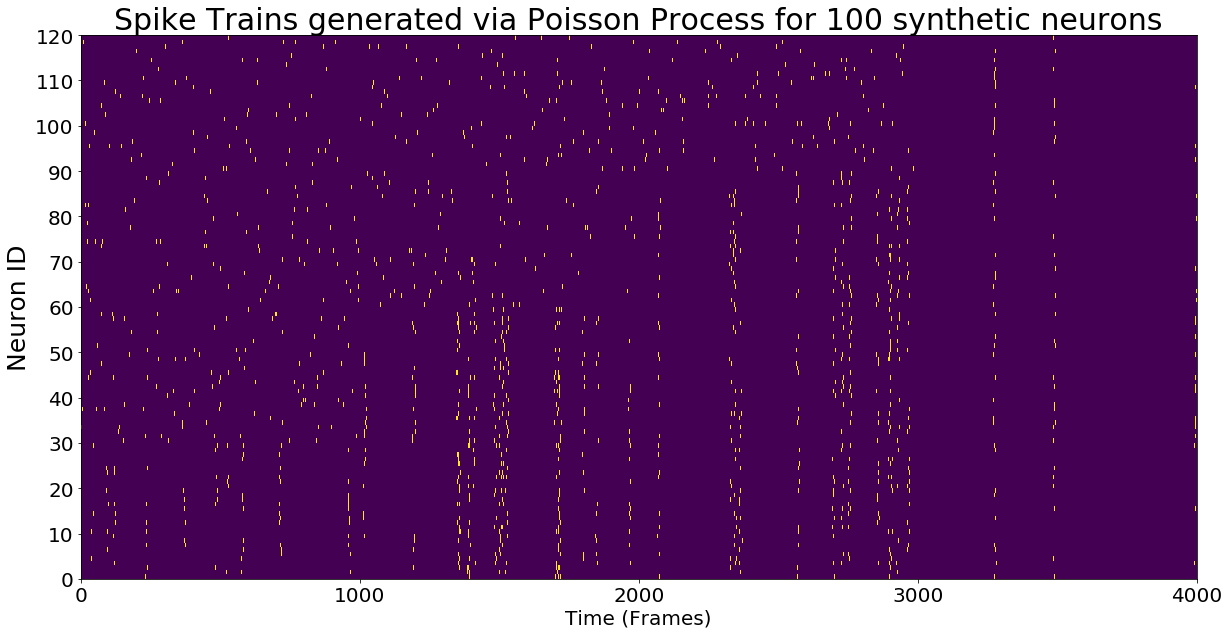

In [7]:
fig,ax = plt.subplots(1, 1, figsize = (20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,4000,0,120])
ax.set_title('Spike Trains generated via Poisson Process for 100 synthetic neurons', fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(5)])
ax.set_yticks([i*10 for i in range(13)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)

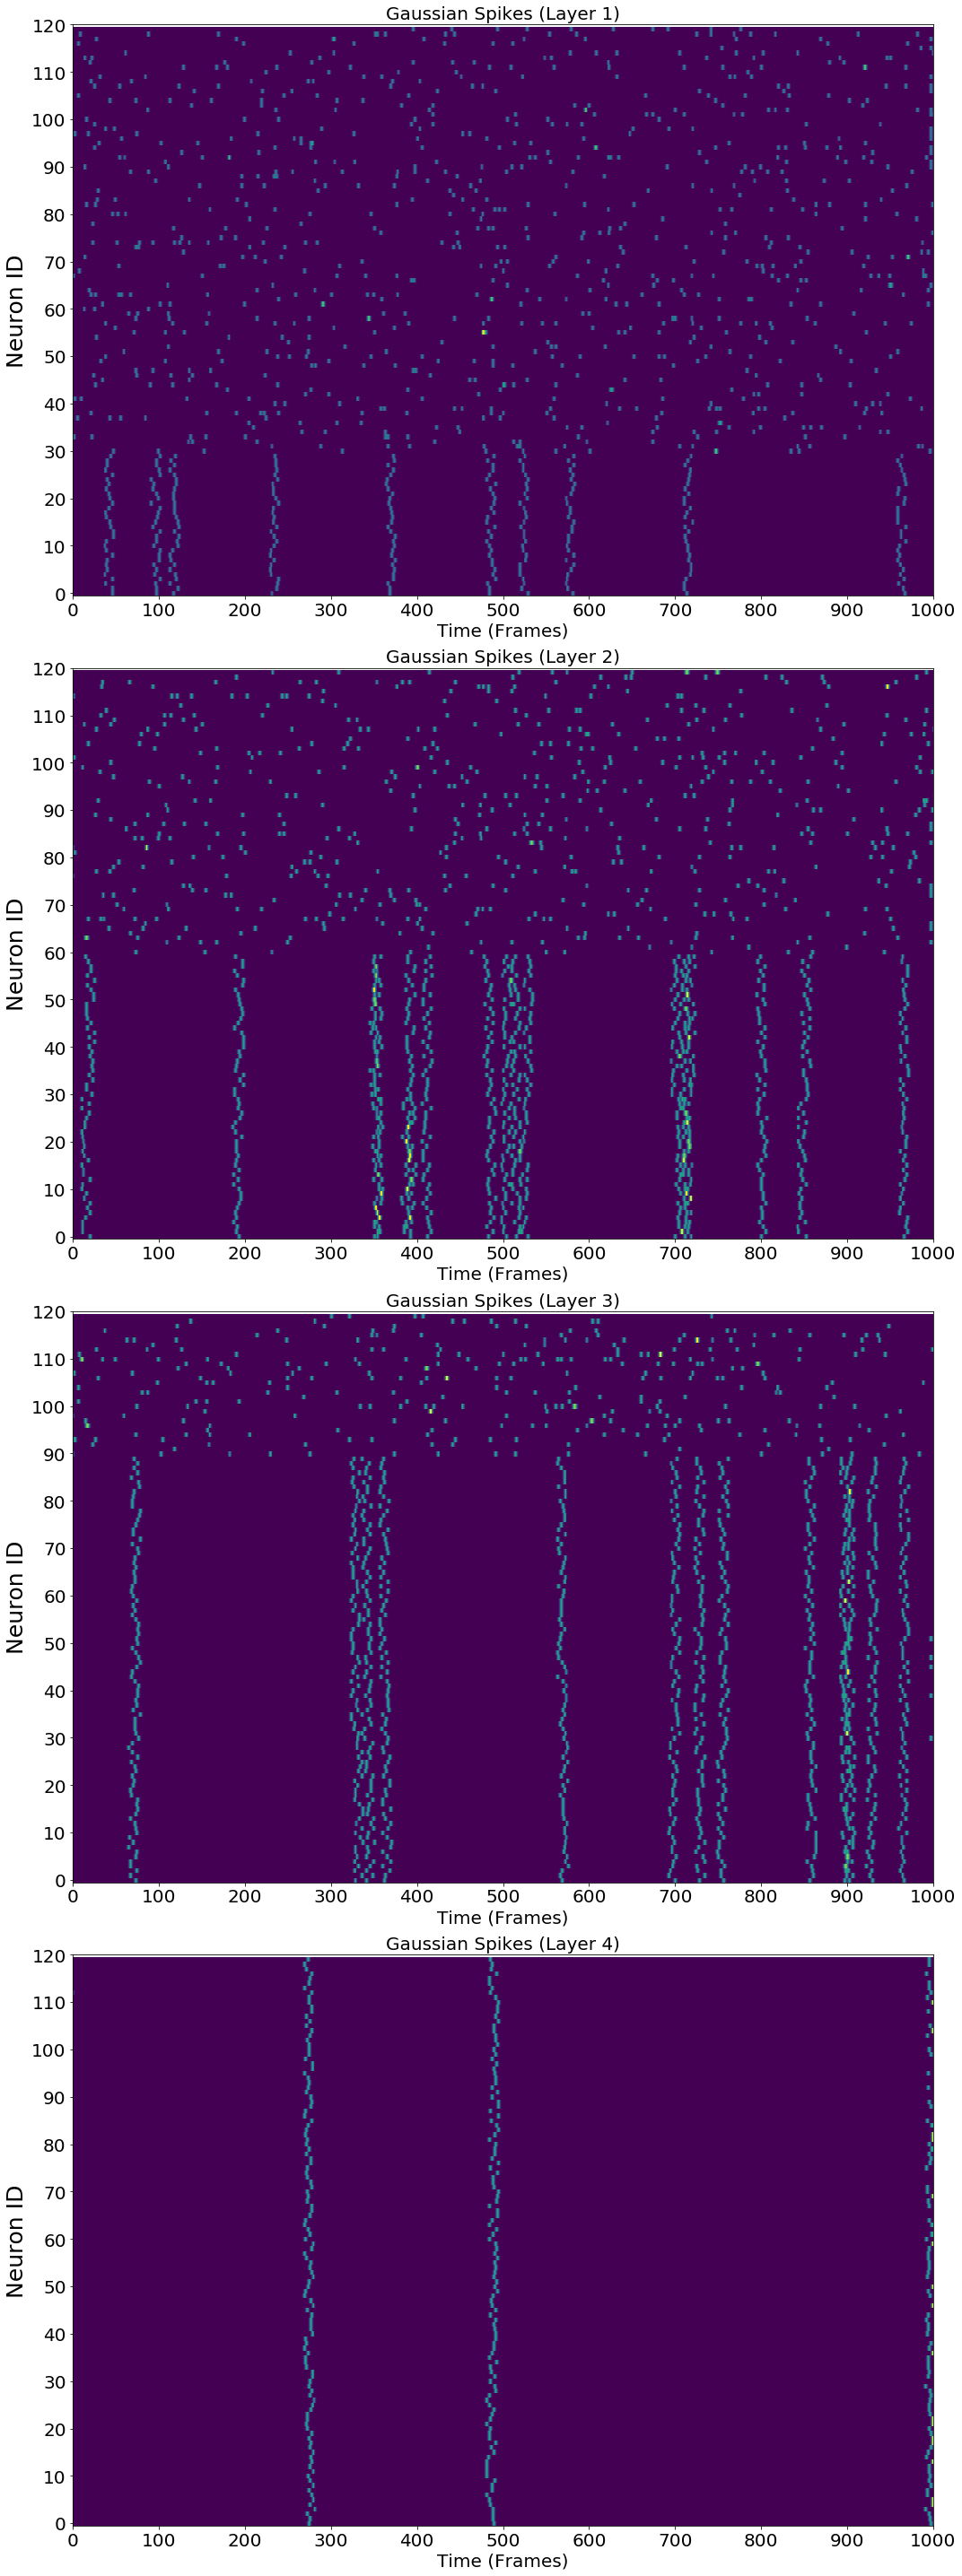

In [8]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,40))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto', extent = [-0.5, window_size-0.5,-0.5,num_neurons-0.5])
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(13)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()

In [9]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


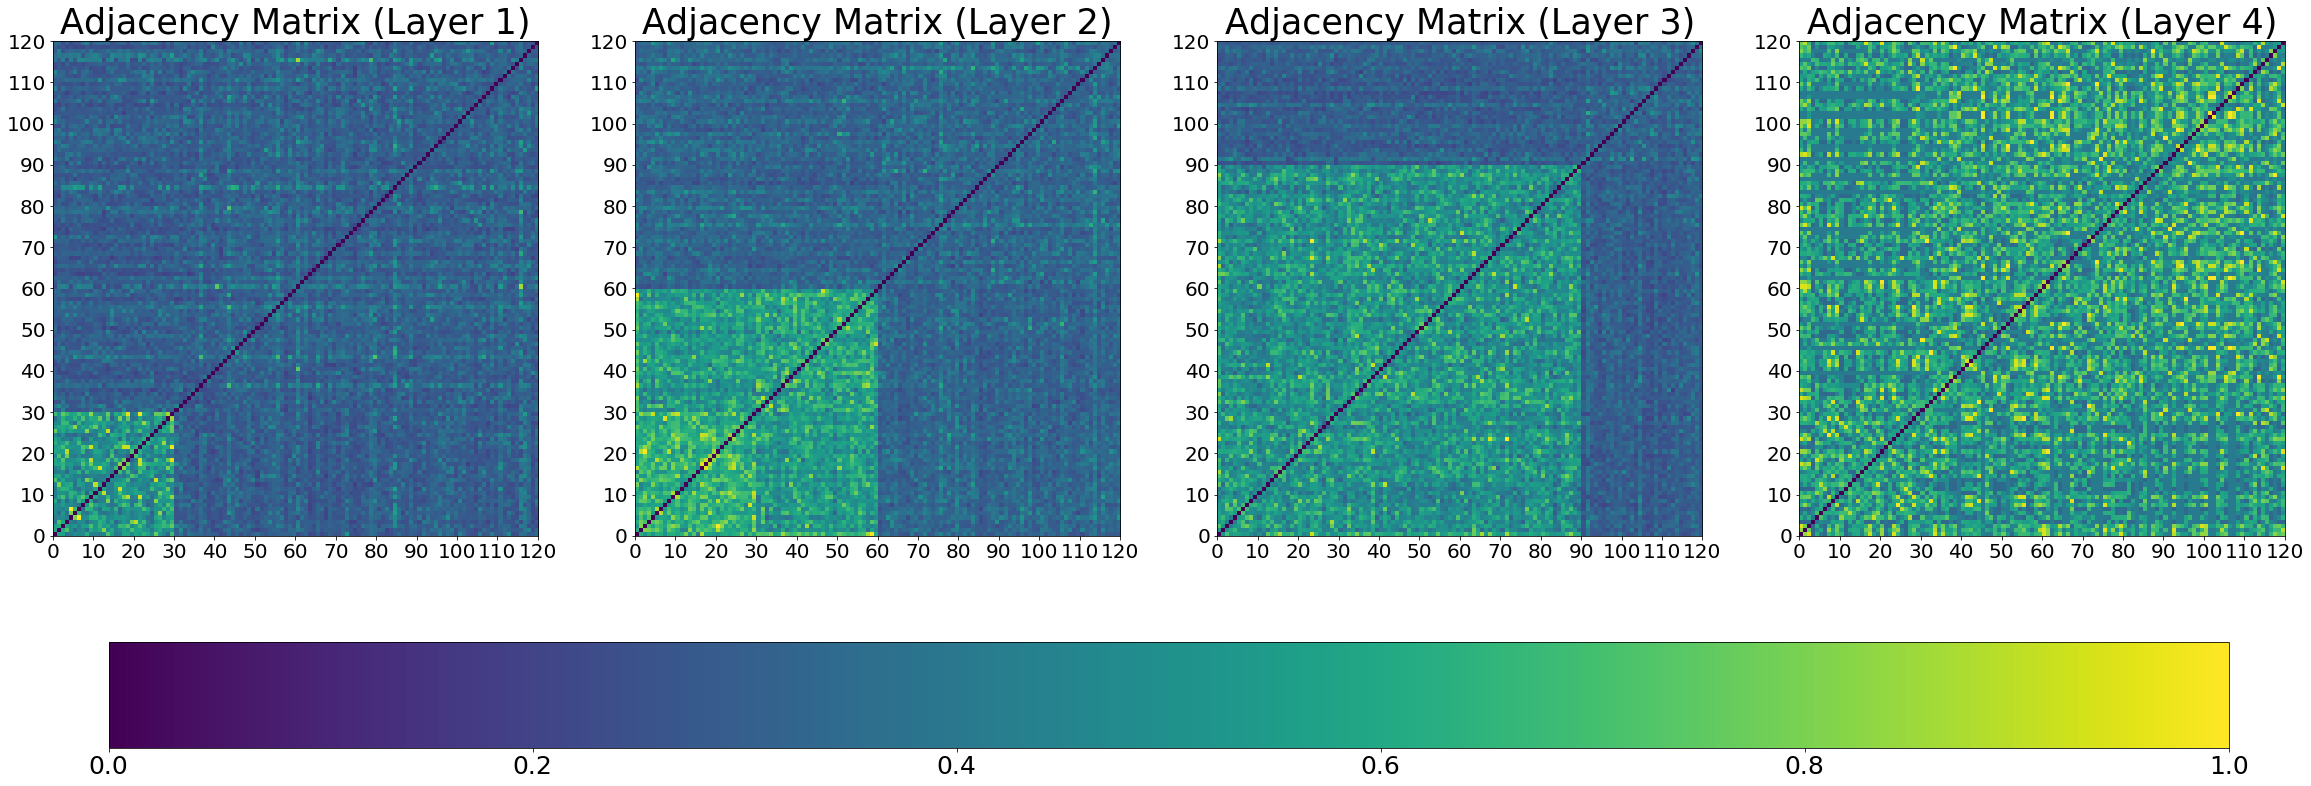

In [10]:
fig,ax = plt.subplots(1,4, figsize = (40,13))
for i in range(4):
        k = ax[i].imshow(adjacency_matrices[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,120,0,120])
        ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 35)
        ax[i].set_xticks([k*10 for k in range(13)])
        ax[i].set_yticks([k*10 for k in range(13)])
        ax[i].tick_params(axis = 'both', labelsize = 20)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 

CPU times: user 22.3 s, sys: 295 ms, total: 22.6 s
Wall time: 23.3 s


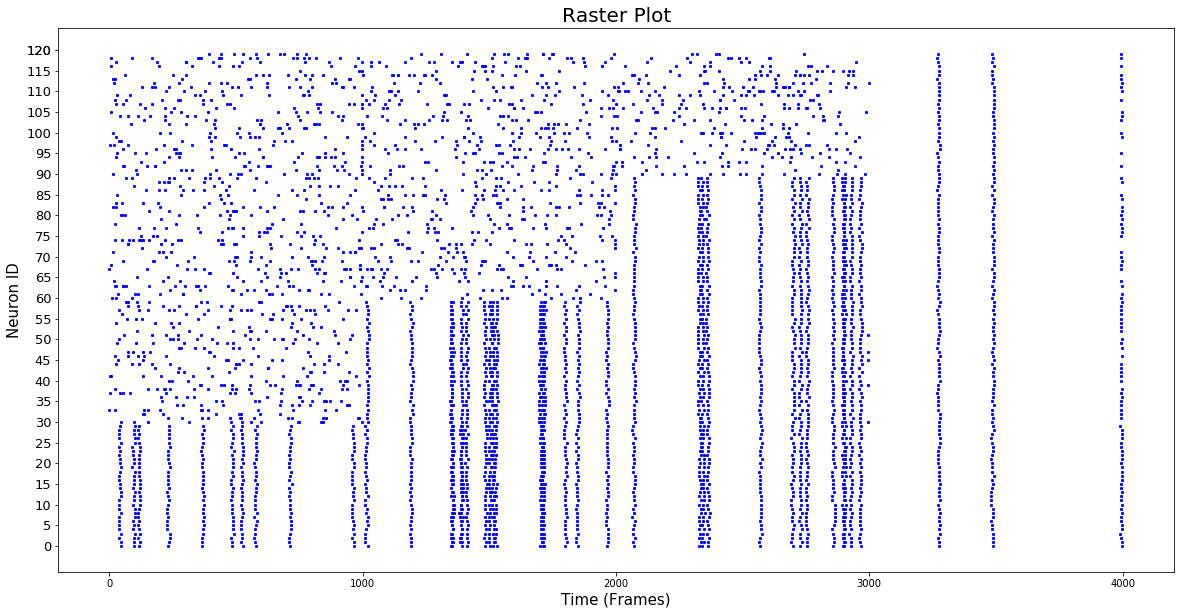

In [11]:
%%time
TN = temporal_network(num_neurons, layers, window_size, data = 'list__adjacency', list_adjacency = adjacency_matrices, omega = 1, kind= 'ordinal')

fig,ax = plt.subplots(1, 1, figsize = (20,10))
TN.raster_plot(spikes, ax)

In [14]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = False)
sp = np.nonzero(binned_spikes)
layers ,num_neurons, t = binned_spikes.shape
count_spikes = np.zeros((layers, num_neurons))
interlayer = np.ones((layers-1, num_neurons))
X = 0.5
percentage = 0.01
for i in range(len(sp[0])):
    l, n, t = sp[0][i], sp[1][i], sp[2][i]
    count_spikes[l][n] = count_spikes[l][n] + 1
interlayers = []
for i in range(layers-1):
    zscores = zscore(np.diff(count_spikes, axis = 0)[i])
    layerweights = []
    for j in range(num_neurons):
        if zscores[j] <= X: layerweights.append(percentage)
        else: layerweights.append(1)
    interlayers.append(layerweights)

In [84]:
def update_interlayer(spikes, window_size, X, percentage, method):
    binned_spikes = bin_time_series(spikes, window_size, gaussian = False)
    sp = np.nonzero(binned_spikes)
    layers ,num_neurons, t = binned_spikes.shape
    count_spikes = np.zeros((layers, num_neurons))
    interlayer = np.ones((layers-1, num_neurons))
    
    if method == 'local':
        for i in range(len(sp[0])):
            l, n, t = sp[0][i], sp[1][i], sp[2][i]
            count_spikes[l][n] = count_spikes[l][n] + 1
        interlayers = []
        for i in range(layers-1):
            zscores = zscore(np.diff(count_spikes, axis = 0)[i])
            layerweights = []
            for j in range(num_neurons):
                if zscores[j] <= X: layerweights.append(percentage)
                else: layerweights.append(1)
            interlayers.append(layerweights)

    elif method == 'global':
        for i in range(len(sp[0])):
            l, n, t = sp[0][i], sp[1][i], sp[2][i]
            count_spikes[l][n] = count_spikes[l][n] + 1
        interlayers = []
        for i in range(layers-1):
            zscores = zscore(sum(np.diff(count_spikes, axis = 0)))
            layerweights = []
            for j in range(num_neurons):
                if zscores[j] <= X: layerweights.append(percentage)
                else: layerweights.append(1)
            interlayers.append(layerweights)
    
    #elif method == 'adjacent':
    
    return(interlayers)

In [88]:
interlayers_global = update_interlayer(spikes, 1000, -0.5, 0.1, method = 'global')
interlayers_local = update_interlayer(spikes, 1000, -0.5, 0.1, method = 'local')

In [66]:
zscores = []
for i in range(layers-1):
    zscores.append(zscore(np.diff(count_spikes, axis = 0)[i]))
masks = []
for i in range(layers-1):
    masks.append(np.diff(count_spikes, axis = 0)[i]>layer_average_change[i])
interlayers = []
for i in range(layers-1):
    layerweights = []
    for j in range(num_neurons):
        if masks[i][j]:layerweights.append(0.1)
        else:layerweights.append(1)
    interlayers.append(layerweights)

(array([[1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
         1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
         1. , 1. , 1. , 1. , 0.1, 1. , 0.1, 1. , 1. , 1. , 1. , 0.1, 0.1,
         1. , 0.1, 0.1, 1. , 1. , 1. , 1. , 0.1, 1. , 1. , 1. , 0.1, 1. ,
         1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.1, 1. , 1. , 1. , 0.1, 1. ,
         1. , 1. , 1. , 1. , 0.1, 1. , 0.1, 0.1, 1. , 1. , 1. , 0.1, 1. ,
         1. , 1. , 0.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.1, 1. , 0.1,
         0.1, 1. , 0.1, 1. , 0.1, 0.1, 1. , 0.1, 1. , 1. , 1. , 0.1, 1. ,
         1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.1, 1. , 0.1, 1. ,
         1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
         1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
         1. , 1. , 1. , 1. , 0.1, 1. , 0.1, 1. , 1. , 1. , 1. , 0.1, 0.1,
         1. , 0.1, 0.1, 1. , 1. , 1. , 1. , 0.1, 1. , 1. , 1. , 0.1, 1. ,
         1. ,

In [80]:
interlayers

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0.1,
  1,
  1,
  1,
  1,
  0.1,
  1,
  1,
  0.1,
  1,
  1,
  1,
  1,
  1,
  0.1,
  1,
  1,
  1,
  0.1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0.1,
  1,
  1,
  0.1,
  1,
  0.1,
  0.1,
  1,
  0.1,
  0.1,
  1,
  0.1,
  1,
  1,
  0.1,
  1,
  0.1,
  0.1,
  1,
  1,
  1,
  0.1,
  0.1,
  1,
  1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  1,
  0.1,
  1,
  0.1,
  1,
  0.1,
  0.1,
  0.1,
  0.1,
  1,
  0.1,
  0.1,
  1,
  1,
  0.1,
  1,
  1,
  1,
  0.1,
  0.1,
  1,
  0.1,
  0.1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0.1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0.1,
  1,
  1,
  1,
  0.1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
 

In [27]:
interslice = 1
interslice = [[]]

In [28]:
layers, interslice_layer, G_full = la.time_slices_to_layers(TN.create_igraph(), interslice_weight = interlayers)

In [29]:
for i in interslice_layer.es:
    print(i)

igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 0, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 1, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 2, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 3, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 4, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 5, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 6, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 7, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 8, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850>, 9, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7f9d65a98850

In [41]:
layers